# Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

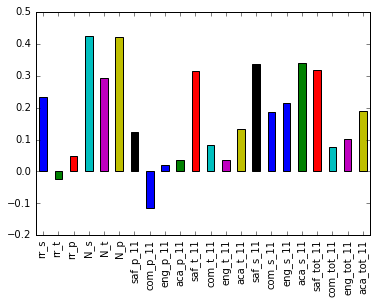

In [11]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

# notes
the positive correlations are moderate. there are only two negative correlations, but they are so close to zero, that there is almost no negative correlations.
the highest positive relations are on N_s (Number of student respondents) and N_p (Number of parent respondents).
so if there are high responses of students or parents, there is also a hight sat_score. my interpretation is that a high number of respondents shows that these students and parents seem to have a higher basic motivation and that is why they take part on surveys to improve the quality of school. because of the higher motivation they have better scores in result. 
this fits to the high positive correlation on the aca_s (Academic expectations score based on student responses).
also you can see that a high sat_score correlates positive to high values on safety and respect like saf_s (Safety and Respect score based on student responses) and sat_t(Safety and Respect score based on teacher responses).

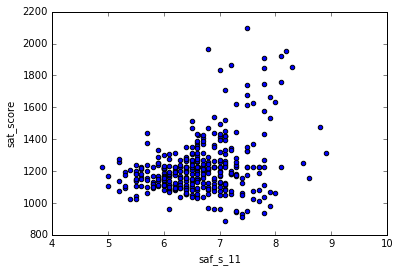

In [12]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

In [13]:
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

## mapping out safety scores on New Yorks boroughs

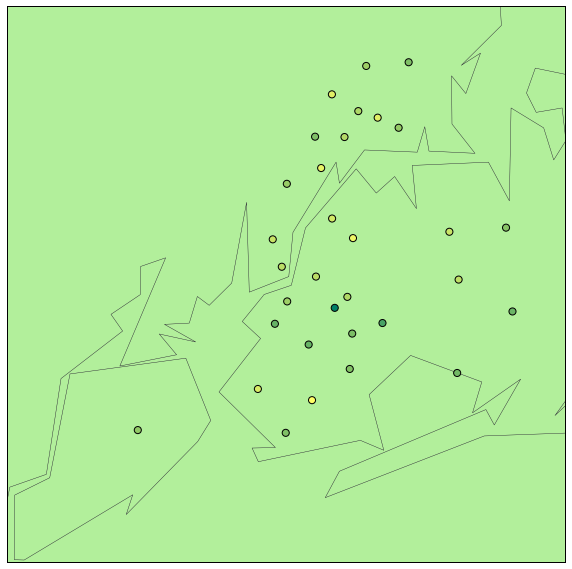

In [14]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(10,10))
m = Basemap(
    projection="merc",
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution="i"
    )
m.drawmapboundary(fill_color="#B2EF9B")
m.drawcoastlines(color="#1E152A", linewidth=.4)
m.drawrivers(color="#1E152A", linewidth=.4)

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_tot_11"], cmap="summer" )

plt.show()

## correlation bar plot on sat_score and race

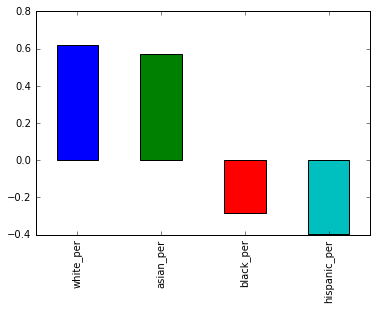

In [15]:
cols = ["white_per","asian_per","black_per","hispanic_per"]
combined.corr()["sat_score"][cols].plot.bar()

### notes
there are very positive correlations between white/asian and a high sat score. negative correlation between black/hispanic and lower sat score. between black and sat score the neg. corr. is weak. 

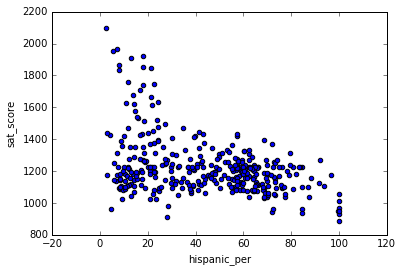

In [16]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

## notes
the scatter plot shows also correlation between hispanic_per and sat_score. if there is a high value of hispanic_per there are no high sat_scores. as the hispanic_per decreases there are more high sat_scores. but also with a low hispanic_per there seems to be a invisible border at about 1500 sat_score which is not passed by the most schools.

## schools with hispanic_per over 95%

In [17]:
hispanic_per_over95 = combined[combined["hispanic_per"] > 95]
hispanic_per_over95

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0,0,0,0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0,0,0,0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0,0,0,0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0,0,0,0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24


### notes on some schools
1. Manhattan Bridges is a small high school located in Hell’s Kitchen that caters to immigrants recently arrived from Spanish-speaking countries.https://insideschools.org/school/02M542
2. Multicultural High School serves students new to the United States who are learning English. We help students learn to read, write, and communicate fluently in English while also providing opportunities to maintain and strengthen their native language.http://www.mhsbk.org/about-us/
3. Students at Pan American International High School all speak Spanish and have been in the United States for less than four years. They come from Ecuador, Honduras, Mexico, Colombia and other countries.https://insideschools.org/school/24Q296

## schools with hispanic_per under 10%

In [18]:
hispanic_per_under10 = combined[combined["hispanic_per"] < 10]
hispanic_per_under10

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.000000,735.000000,682.000000,2096.000000,STUYVESANT HS,1510.000000,2819.000000,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.000000,581.000000,431.000000,1424.000000,High School for Dual Language and Asian Studies,61.000000,96.000000,...,0,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.000000,688.000000,649.000000,1969.000000,BRONX HS OF SCIENCE,1190.000000,2435.000000,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.000000,659.000000,587.000000,1833.000000,BROOKLYN TECHNICAL HS,2117.000000,3692.000000,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
192,13K595,BEDFORD ACADEMY HIGH SCHOOL,89,438.000000,443.000000,431.000000,1312.000000,Bedford Academy High School,43.000000,57.000000,...,0,0,0,0,0,0,"1119 Bedford Avenue\nBrooklyn, NY 11216\n(40.6...",40.685381,-73.954268,13
194,13K670,BENJAMIN BANNEKER ACADEMY,185,471.000000,472.000000,448.000000,1391.000000,BENJAMIN BANNEKER ACADEMY,132.000000,149.000000,...,0,0,0,0,0,0,"71-77 Clinton Avenue\nBrooklyn, NY 11205\n(40....",40.695662,-73.969286,13
220,16K455,BOYS AND GIRLS HIGH SCHOOL,131,365.000000,370.000000,362.000000,1097.000000,BOYS AND GIRLS HS,22.000000,32.000000,...,0,0,0,0,0,0,"1700 Fulton Street\nBrooklyn, NY 11213\n(40.67...",40.679433,-73.932432,16
223,17K382,ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...,59,396.000000,374.000000,369.000000,1139.000000,Academy for College Preparation and Career Exp...,64.000000,82.000000,...,0,0,0,0,0,0,"911 Flatbush Avenue\nBrooklyn, NY 11226\n(40.6...",40.649440,-73.958431,17
226,17K528,THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP,46,403.000000,385.000000,388.000000,1176.000000,"High School for Global Citizenship, The",20.000000,34.000000,...,0,0,0,0,0,0,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67...",40.670299,-73.961648,17
227,17K531,"SCHOOL FOR HUMAN RIGHTS, THE",35,348.000000,381.000000,359.000000,1088.000000,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"600 Kingston Avenue\nBrooklyn, NY 11203\n(40.6...",40.659517,-73.942546,17


### notes
1. Stuyvesant High School has been a symbol of excellence in education for over a century. Our mission is to continue and enhance that commitment by providing an environment which will nurture and enhance the special academic talents of the students admitted to Stuyvesant. The educational heritage of Stuyvesant is deeply rooted in the tradition of Science, Mathematics and Technology. https://stuy.enschool.org/apps/pages/index.jsp?uREC_ID=126631&type=d&pREC_ID=251661&hideMenu=1
2. At the High School for Dual Language and Asian Studies, all students are expected to speak, read and write in English and Chinese by the time they graduate. It is an academically demanding school where teens are required to study Mandarin daily and take four years of math and science. Attendance is near perfect, as is the four-year graduation rate.https://insideschools.org/school/02M545
3. The School for Human Rights is a safe school that does an impressive job helping students with special needs graduate on time. Test scores have a ways to go but the school boasts good attendance and steady leadership. Almost all teachers would recommend the school to other families. https://insideschools.org/school/17K531

very interesting that a school like "the school for human rights" has a hispanic_per under 10%. did not expect that.

# schools with hispanic_per under 10% and sat over 1800

In [19]:
hispanic_per_under10_high_sat = hispanic_per_under10[hispanic_per_under10["sat_score"] > 1800]
hispanic_per_under10_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


## notes
remarkable is that all schools have technical/science focus.

# taking a look on gender

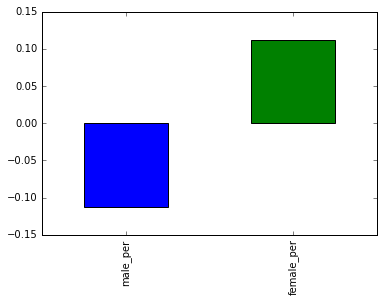

In [20]:
combined.corr()["sat_score"][["male_per","female_per"]].plot.bar()

## notes
both genders with same values with the difference that male has neg. corr. while female has a pos. corr. but these values are so weak an nearly zero that i would say, there is no correlation between gender and sat_score

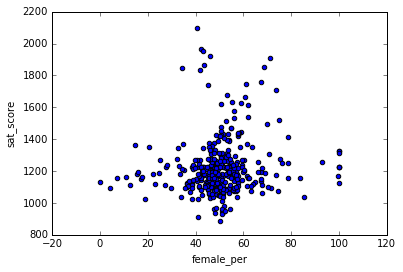

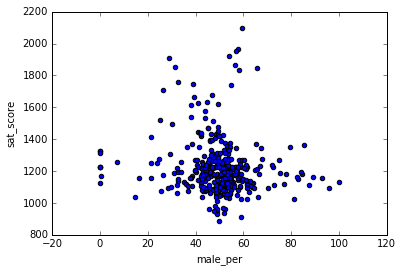

In [21]:
combined.plot.scatter(x="female_per", y="sat_score")
combined.plot.scatter(x="male_per", y="sat_score")

## notes
male and female nearly have the same output. in most schools both genders are around 50%. but there seems to be a weak bias that schools with high male_per values like over 65% have no high sat_score.

In [22]:
high_fem = combined[combined["female_per"] > 60]
high_fem_sat = high_fem[high_fem["sat_score"] > 1700]
high_fem_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


## notes
1. Townsend Harris High School is ranked 7th within New York. Students have the opportunity to take Advanced Placement® course work and exams. The AP® participation rate at Townsend Harris High School is 100 percent. The student body makeup is 31 percent male and 69 percent female, and the total minority enrollment is 78 percent. Townsend Harris High School is 1 of 524 high schools in the New York City Public Schools.https://www.usnews.com/education/best-high-schools/new-york/districts/new-york-city-public-schools/townsend-harris-high-school-13434
2. Bard High School Early College (BHSEC) offers small class sizes, excellent teaching, and the promise of two years of college credit for free. The demanding, fast-paced curriculum has attracted some of the city's best students. Students complete their high school requirements in two years and then embark on college work. After four years, they receive both a Regents diploma and an associate's degree.https://insideschools.org/school/01M696

# combining AP Test Takers and sat_score

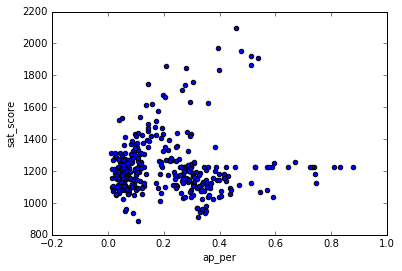

In [24]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]
combined.plot.scatter(x="ap_per", y="sat_score")

# finally loo

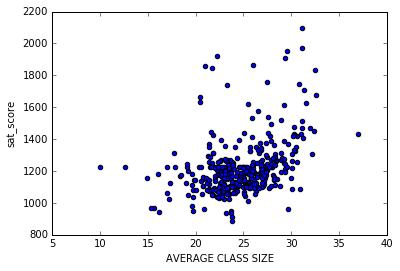

In [26]:
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")